In [1]:
import jax
import jax.numpy as jnp
from jax import jit, vmap

import matplotlib.pyplot as plt
from cProfile import Profile


In [46]:
#  set TF_CPP_MIN_LOG_LEVEL=0

TF_CPP_MIN_LOG_LEVEL=0
# see if jax is using GPU
print(jax.devices())

[cuda(id=0)]


In [2]:
def correlate_weiner_process(X, L, dt):
    return jnp.sqrt(dt) * L @ X

def update_process(xt, dt, alpha, mu, sigma, dZt):
    dxt_drift = alpha * (mu - xt) * dt
    dxt_stochastic_variation = sigma * jnp.sqrt(xt) * dZt

    return xt + dxt_drift + dxt_stochastic_variation

def generate_process(x0, alpha, mu, sigma, dZ):
    x = jnp.zeros(len(dZ))
    x.at[0].set(x0)

    for i in range(1, len(dZ)):
        x = x.at[i].set(update_process(x[i-1], 1, alpha, mu, sigma, dZ[i]))
    
    return x

         362387 function calls in 0.370 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1404    0.070    0.000    0.088    0.000 dispatch.py:79(apply_primitive)
     1388    0.053    0.000    0.056    0.000 array_methods.py:259(deferring_binary_op)
     5802    0.017    0.000    0.035    0.000 dtypes.py:644(dtype)
    10412    0.017    0.000    0.032    0.000 dtypes.py:329(issubdtype)
    64217    0.013    0.000    0.019    0.000 {built-in method builtins.isinstance}
      398    0.010    0.000    0.093    0.000 lax_numpy.py:4503(_attempt_rewriting_take_via_slice)
    28468    0.009    0.000    0.013    0.000 config.py:275(value)
      198    0.008    0.000    0.064    0.000 3703010314.py:4(update_process)
      200    0.008    0.000    0.027    0.000 lax_numpy.py:887(squeeze)
     1402    0.007    0.000    0.065    0.000 lax.py:518(_convert_element_type)
      600    0.006    0.000    0.049    0.000 lax_numpy.py:2101(

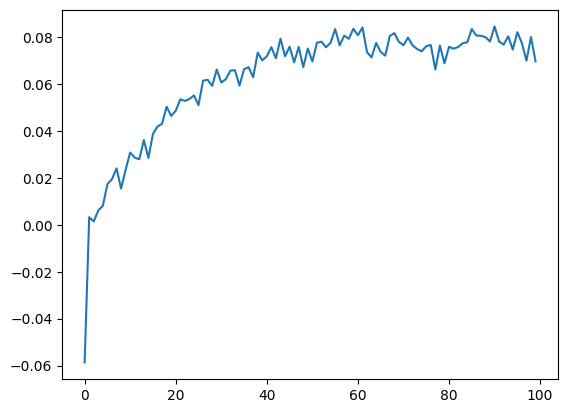

In [54]:
n_years = 100
dt = 1 / 12

n_factors = 2

n_runs = 1000
key = jax.random.PRNGKey(0)
X = jax.random.normal(key=key, shape=(n_factors, n_years))

rho = - 0.739
weiner_sigma = jnp.array([[1, rho], [rho, 1]])
weiner_L = jnp.linalg.cholesky(weiner_sigma).T

dZ = correlate_weiner_process(X, weiner_L, dt)

# Initial values
x_10 = 0.0228
x_20 = 0.0809
# Parameters
a_1 = 1.0682
m_1 = 0.0546
s_1 = 0.0412
a_2 = 0.0469
m_2 = 0.0778
s_2 = 0.0287


with Profile() as profile:
    x_1 = generate_process(x_10, a_1, m_1, s_1, dZ[0])
    x_2 = generate_process(x_20, a_2, m_2, s_2, dZ[1])

    phi = 0.045 - (x_10 + x_20)
    n = phi + x_1 + x_2
    print(profile.print_stats(sort='tottime'))

plt.plot(n)

In [8]:
n_runs = 50000

n_years = 100
dt = 1 / 12

n_factors = 2

# Initial values
x = jnp.array([0.0228, 0.0809])
# Parameters
a = jnp.array([1.0682, 0.0469])
m = jnp.array([0.0546, 0.0778])
s = jnp.array([0.0412, 0.0287])

# run all runs simultaneously
key = jax.random.PRNGKey(0)
X = jax.random.normal(key=key, shape=(n_runs, n_factors, n_years))

rho = - 0.739
weiner_sigma = jnp.array([[1, rho], [rho, 1]])
weiner_L = jnp.linalg.cholesky(weiner_sigma).T

# use vmap to get all dZs
dZ = vmap(correlate_weiner_process, in_axes=(0, None, None))(X, weiner_L, dt)

x1 = vmap(generate_process, in_axes=(None, None, None, None, 0))(x[0], a[0], m[0], s[0], dZ[:, 0,:])
x2 = vmap(generate_process, in_axes=(None, None, None, None, 0))(x[1], a[1], m[1], s[1], dZ[:, 1,:])

phi = 0.045 - (x[0] + x[1])
n = phi + x1 + x2

plt.plot(n.T)
